<a href="https://colab.research.google.com/github/CategoricalCrossEntropy/Adaptive_pooling/blob/main/Visual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.autograd import Variable
from PIL import Image,ImageOps
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import cv2
from cv2 import resize
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Loss: -4.21523
Imgshape :  torch.Size([1, 3, 67, 67])
Loss: -6.9694223
Imgshape :  torch.Size([1, 3, 80, 80])
Loss: -8.037503
Imgshape :  torch.Size([1, 3, 96, 96])
Loss: -8.271497
Imgshape :  torch.Size([1, 3, 115, 115])
Loss: -7.8407245
Imgshape :  torch.Size([1, 3, 138, 138])
Loss: -7.230979
Imgshape :  torch.Size([1, 3, 165, 165])
Loss: -6.8811855
Imgshape :  torch.Size([1, 3, 198, 198])
Loss: -6.5902305
Imgshape :  torch.Size([1, 3, 237, 237])
Loss: -6.1845202
Imgshape :  torch.Size([1, 3, 284, 284])


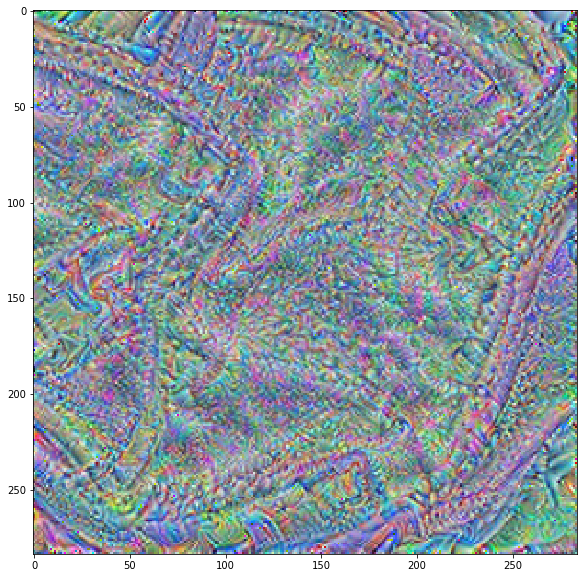

In [ ]:
layer = 40
filters = [13]

sz = 56
img = np.uint8(np.random.uniform(150, 180, (3, sz, sz)))/255
img = torch.from_numpy(img[None]).float().to(device)

model_vgg16 = models.vgg16_bn(pretrained=True).features.to(device).eval()

class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        # self.features = output.clone().detach().requires_grad_(True)
        self.features = output.clone()
    def close(self):
        self.hook.remove()

activations = SaveFeatures(list(model_vgg16.children())[layer])

lr = 0.1
opt_steps = 20
upscaling_steps = 9
blur=1
upscaling_factor=1.2

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)


for epoch in range(upscaling_steps):
    img = (img - cnn_normalization_mean) / cnn_normalization_std
    img[img>1]=1
    img[img<0]=0
    #print('Imgshape1 : ',img.shape)
    img_var = Variable(img, requires_grad=True)

    optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
    for n in range(opt_steps):
        optimizer.zero_grad()
        model_vgg16(img_var)
        loss = -activations.features[0, filters].mean()
        loss.backward()
        optimizer.step()

    print('Loss:',loss.cpu().detach().numpy())
    img = img_var * cnn_normalization_std + cnn_normalization_mean
    img[img>1]=1
    img[img<0]=0
    img = img.data.cpu().numpy()[0].transpose(1,2,0)
    sz = int(upscaling_factor * sz)
    img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)
    if blur is not None: img = cv2.blur(img,(blur,blur))
    #print('Imgshape2 : ',img.shape)
    img = torch.from_numpy(img.transpose(2,0,1)[None]).to(device)
    print('Imgshape : ',img.shape)
    #print(str(epoch),',Finished')
    #print('=======')

activations.close()

image = img.cpu().clone()
image = image.squeeze(0)
unloader = transforms.ToPILImage()

image = unloader(image)
image = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR) 
cv2.imwrite('res1.jpg',image)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, interpolation='nearest')
#plt.imshow(image, interpolation='nearest', aspect='auto')
torch.cuda.empty_cache()